In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tensorflow as tf

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict
from keras.layers import LSTM
from keras.layers import GRU

Using TensorFlow backend.


In [2]:
# Swish Activation Function
def swish(x):
    return x * tf.nn.sigmoid(x)

###  Stocks data (1990 ~ 2019)

In [13]:
stocks = pd.read_csv('C:/Users/dip/Desktop/compu_finance_finalproject/stocks.csv')
stocks = stocks.set_index(pd.DatetimeIndex(stocks['date']))
stocks = stocks.drop(['date'], axis=1)

stocks = stocks[stocks.index.dayofweek < 5] # business day only
stocks_return = stocks.pct_change()

In [14]:
stocks_lp = stocks[2:]
stocks_lp_bf = stocks_lp.fillna(method='bfill')

In [15]:
stocks_return = stocks_return[2:]
stocks_return_mf = stocks_return.fillna(stocks_return.mean())

### Stocks data (1995 ~ 2019)

In [16]:
stocks95 = stocks['1995':]
stocks95_return = stocks95.pct_change()

In [17]:
# 95 last price // 95 stock return dataframe

stocks95_lp = stocks95[2:]
stocks95_lp_zf = stocks95_lp.fillna(0)

stocks95_return = stocks95_return[2:]
stocks95_return_mf = stocks95_return.fillna(0)

### Stocks data (2000 ~ 2019)

In [18]:
stocks00 = stocks['2000':]
stocks00_return = stocks00.pct_change()

In [19]:
# 2000 last price // 2000 stock return dataframe

stocks00_lp = stocks00[2:]
stocks00_lp_zf = stocks00_lp.fillna(0)

stocks00_return = stocks00_return[2:]
stocks00_return_mf = stocks00_return.fillna(0)

###  Stocks data (2015 ~ 2019)

In [20]:
stocks15

NameError: name 'stocks15' is not defined

In [21]:
stocks15 = stocks['2015':]
stocks15_return = stocks15.pct_change()

In [22]:
# 2000 last price // 2000 stock return dataframe

stocks15_lp = stocks15[2:]
stocks15_lp_zf = stocks15_lp.fillna(0)

stocks15_return = stocks15_return[2:]
stocks15_return_mf = stocks15_return.fillna(0)

In [23]:
stock15 = defaultdict(defaultdict)

stock15['calibrate']['lp'] = stocks15_lp_zf[:642]
stock15['validate']['lp'] = stocks15_lp_zf[642:]

stock15['calibrate']['pct'] = stocks15_return_mf[:642]
stock15['validate']['pct'] = stocks15_return_mf[642:]

###  Kospi data (1990 ~ // 1995 ~ // 2000 ~ )

In [24]:
kospi = pd.read_csv('C:/Users/dip/Desktop/compu_finance_finalproject/kospi.csv')
kospi = kospi.set_index(pd.DatetimeIndex(kospi['date']))
kospi = kospi[kospi.index.dayofweek < 5]
kospi = kospi.drop(['date', 'pct_change'], axis=1)
kospi['pct_change'] = kospi['kospi_index'].pct_change()*100
kospi = kospi.dropna()
kospi = kospi[1:]

In [25]:
kospi95 = kospi['1995':]
kospi00 = kospi['2000':]
kospi15 = kospi['2015':]

In [26]:
# kospi data

kspi15 = defaultdict(defaultdict)

kospi15_lp = kospi15.iloc[2:,0] # Series
kspi15['calibrate']['lp'] = kospi15_lp[:642]
kspi15['validate']['lp'] = kospi15_lp[642:]

kospi15_percentage = kospi15.iloc[2:,2] # Series
kspi15['calibrate']['pct'] = kospi15_percentage[:642]
kspi15['validate']['pct'] = kospi15_percentage[642:]

# Part 1 : Retracking the KOSPI Index

###    Phase1 : Autoencoder Modeling (Stock Selection)

In [16]:
encoding_dim = 7 # 7 neurons
num_stock = len(stocks15_lp_zf.columns) # Use 791 stocks as features

# Encoding and Decoding layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation=swish, kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation='linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock15['calibrate']['pct']
autoencoder.fit(data, data, shuffle=False, epochs=100, batch_size = 10)

Epoch 1/100
642/642 [==============================] - 1s 873us/step - loss: 0.2757
Epoch 2/100
642/642 [==============================] - 0s 224us/step - loss: 0.2686
Epoch 3/100
642/642 [==============================] - 0s 244us/step - loss: 0.2617
Epoch 4/100
642/642 [==============================] - 0s 253us/step - loss: 0.2550
Epoch 5/100
642/642 [==============================] - 0s 252us/step - loss: 0.2485
Epoch 6/100
642/642 [==============================] - 0s 247us/step - loss: 0.2421
Epoch 7/100
642/642 [==============================] - 0s 245us/step - loss: 0.2359
Epoch 8/100
642/642 [==============================] - 0s 227us/step - loss: 0.2299
Epoch 9/100
642/642 [==============================] - 0s 228us/step - loss: 0.2240
Epoch 10/100
642/642 [==============================] - 0s 233us/step - loss: 0.2183
Epoch 11/100
642/642 [==============================] - 0s 233us/step - loss: 0.2127
Epoch 12/100
642/642 [==============================] - 0s 232us/step - lo

In [17]:
#autoencoder.save('AE_model/retrack_autoencoder.h5')
autoencoder.save('AE_model/retrack_autoencoder_2015_50_final_1220.h5')

In [18]:
# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

In [19]:
communal_information = []

for i in range(0,791):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock15['calibrate']['pct'].iloc[:,stock_index].name) # print stock name from lowest different to highest

stock #, 2-norm, stock name
630 0.0029172143369332252 SK Chemicals Co Ltd
765 0.002971553584063596 LOTTE Reit Co Ltd
124 0.003554981628675243 Xi S&D Inc
66 0.003639732767969019 Orion Corp/Republic of Korea
476 0.0036600076251709695 Hyosung Heavy Industries Corp
243 0.0038842522930548264 Shinhan Alpha REIT Co Ltd
774 0.003931002464457403 Air Busan Co Ltd
479 0.003931563851090277 Hyosung Chemical Corp
478 0.003954426758900771 Hyosung TNC Co Ltd
601 0.003968130814781795 Dreamtech Co Ltd
687 0.003982396712107563 CENTRAL MOTEK Co Ltd
160 0.0041206375806896525 Jin Air Co Ltd
298 0.0041250060014928 Lotte Data Communication Co
642 0.004183183514073881 Hana Pharm Co Ltd
531 0.004217558509482753 Samyang Packaging Corp
689 0.0044543102112509165 Hyundai Energy Solutions Co Ltd
144 0.00446805086325249 Cuckoo Homesys Co Ltd
355 0.004473322847889354 HDC Hyundai Development Co-Engineering &
327 0.004548531562783841 Jeil Pharmaceutical Co Ltd
666 0.004553928873976385 Asiana IDT Inc
456 0.00460325561039

In [49]:
stock_tsne = pd.read_csv('C:/Users/dip/Desktop/compu_finance_finalproject/stock_tsne.csv', index_col='name')

In [50]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

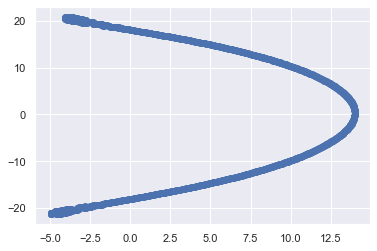

In [59]:
model = TSNE(learning_rate=100, perplexity=80.0 )
transformed = model.fit_transform(stock_tsne)
labels = pd.DataFrame(stock_tsne[["rank"]])
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys)

plt.show()

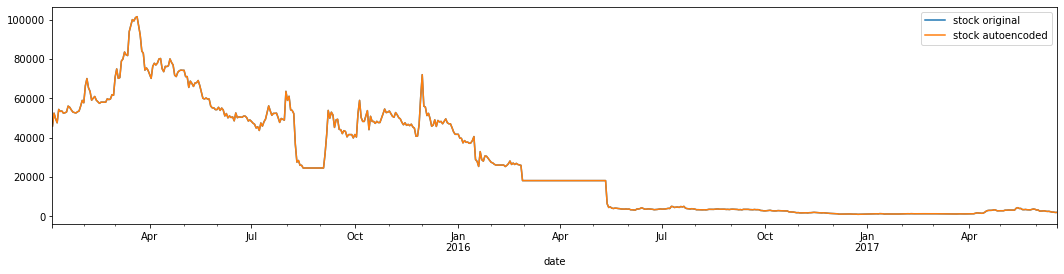

In [20]:
# checking the recovery performance for a single stock
which_stock = 267

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
#stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder = (stock15['calibrate']['lp'].iloc[:, which_stock])

## plot for comparison
fig = plt.figure(figsize=(2^16,2^6))
pd.Series(stock15['calibrate']['lp'].iloc[:, which_stock], index=kospi15_lp.index[:642]).plot(label='stock original', legend=True) #index=pd.date_range(start='01/02/1995', periods=2590, freq='D'))
pd.Series(stock_autoencoder, index=kospi15_lp.index[:642]).plot(label='stock autoencoded', legend=True) #index=pd.date_range(start='01/03/1990', periods=780, freq='W')

###  Phase 2 : Calibrating (Neural Net)

In [21]:
kspi15_predict = defaultdict(defaultdict)
total_2_norm_diff15 = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [140, 330, 520]:  
    # some numerical values
    encoding_dim = 7
    s = 150 + non_communal
    stock_index = np.concatenate((ranking[0:150], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation=swish, kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock15['calibrate']['pct'].iloc[:, stock_index]
    y = kspi15['calibrate']['pct']
    y = pd.DataFrame(y)
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    #dl_scalery = StandardScaler()
    #dl_scalery.fit(y)
    #y = dl_scalery.transform(z)
    
    
    
    deep_learner.fit(x, y, shuffle=False, epochs=50, batch_size = 10)    # fit the model
    deep_learner.save('AE_model/D7_retrack_2015_50_1220' + str(s) + '.h5') # for validation phase use
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    kspi15_predict['calibrate'][s] = kspi15['calibrate']['lp'][0] * (relative_percentage.cumprod())
    total_2_norm_diff15['calibrate'][s] = np.linalg.norm((kspi15_predict['calibrate'][s] - kspi15['calibrate']['lp']))

Epoch 1/50
642/642 [==============================] - 0s 282us/step - loss: 0.8126
Epoch 2/50
642/642 [==============================] - 0s 224us/step - loss: 0.3587
Epoch 3/50
642/642 [==============================] - 0s 233us/step - loss: 0.2946
Epoch 4/50
642/642 [==============================] - 0s 226us/step - loss: 0.2600
Epoch 5/50
642/642 [==============================] - 0s 241us/step - loss: 0.2359
Epoch 6/50
642/642 [==============================] - 0s 244us/step - loss: 0.2171
Epoch 7/50
642/642 [==============================] - 0s 217us/step - loss: 0.2019
Epoch 8/50
642/642 [==============================] - 0s 211us/step - loss: 0.1891
Epoch 9/50
642/642 [==============================] - 0s 206us/step - loss: 0.1782
Epoch 10/50
642/642 [==============================] - 0s 217us/step - loss: 0.1689
Epoch 11/50
642/642 [==============================] - 0s 218us/step - loss: 0.1607
Epoch 12/50
642/642 [==============================] - 0s 213us/step - loss: 0.1536
E

S290 2-norm difference:  2789.4109955787644
S480 2-norm difference:  1236.560213987366
S670 2-norm difference:  722.8273676901531
Fix Rank: 150
Encoding Dim: 7
Enco Acti: swish
Deco Acti: linear


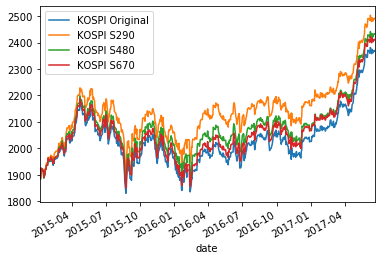

In [22]:
kospi15_plot = pd.DataFrame(kspi15['calibrate']['lp'], index=kospi15_lp.index[:642])
plt.plot(kospi15_plot, label='KOSPI Original')
pd.Series(kspi15_predict['calibrate'][240+50], index=kospi15_lp.index[:642]).plot(label='KOSPI S290')
pd.Series(kspi15_predict['calibrate'][430+50], index=kospi15_lp.index[:642]).plot(label='KOSPI S480')
pd.Series(kspi15_predict['calibrate'][620+50], index=kospi15_lp.index[:642]).plot(label='KOSPI S670')

print("S" + str(240+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][240+50])
print("S" + str(430+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][430+50])
print("S" + str(620+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][620+50])
print("Fix Rank: 150")
print("Encoding Dim: 7")
print("Enco Acti: swish")
print("Deco Acti: linear")

plt.legend()
plt.show()

###  Phase 3 : Validating (Neural Net)

In [23]:
# Validation Code for Neural Net 

for non_communal in [140, 330, 520]:  
    # some numerical values
    encoding_dim = 7
    s = 150 + non_communal
    stock_index = np.concatenate((ranking[0:150], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('AE_model/D7_retrack_2015_50_1220' + str(s) + '.h5', custom_objects={"swish":swish})
        
    x = stock15['validate']['pct'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    kspi15_predict['validate'][s] = kspi15['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff15['validate'][s] = np.linalg.norm((kspi15_predict['validate'][s] - kspi15['validate']['lp']))

S290 2-norm difference:  14103.522527446057
S480 2-norm difference:  11484.828815392957
S670 2-norm difference:  2580.2405828792344
Model : D7_retrack_2015_300_1
Dimension : 7


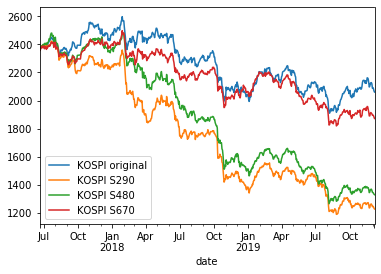

In [24]:
# Validation Plot for Neural Net

# plot results and 2-norm differences
pd.Series(kspi15['validate']['lp'].values, index=kospi15_lp.index[642:]).plot(label='KOSPI original', legend=True)

for s in [290, 480, 670]: #   
    pd.Series(kspi15_predict['validate'][s], index=kospi15_lp.index[642:]).plot(label='KOSPI S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff15['validate'][s])

print("Model : D7_retrack_2015_300_1")
print("Dimension : 7")

### Phase 4 : Verifying

In [25]:
error = []
for non_communal in range(1, 791, 20):  
    
    # some numerical values
    encoding_dim = 7
    s = 150 + non_communal
    stock_index = np.concatenate((ranking[0:150], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation=swish, kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock15['calibrate']['pct'].iloc[:, stock_index]
    y_train = kspi15['calibrate']['pct']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=50, batch_size = 10)    # fit the model


    # testing
    x_test = stock15['validate']['pct'].iloc[:, stock_index]
    y_test = kspi15['validate']['pct']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = kspi15['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - kspi15['validate']['lp'])))


Epoch 1/50
642/642 [==============================] - 0s 272us/step - loss: 0.7646
Epoch 2/50
642/642 [==============================] - 0s 211us/step - loss: 0.3731
Epoch 3/50
642/642 [==============================] - 0s 215us/step - loss: 0.3036
Epoch 4/50
642/642 [==============================] - 0s 214us/step - loss: 0.2697
Epoch 5/50
642/642 [==============================] - 0s 218us/step - loss: 0.2480
Epoch 6/50
642/642 [==============================] - 0s 214us/step - loss: 0.2323
Epoch 7/50
642/642 [==============================] - 0s 214us/step - loss: 0.2200
Epoch 8/50
642/642 [==============================] - 0s 207us/step - loss: 0.2099
Epoch 9/50
642/642 [==============================] - 0s 226us/step - loss: 0.2014
Epoch 10/50
642/642 [==============================] - 0s 206us/step - loss: 0.1940
Epoch 11/50
642/642 [==============================] - 0s 273us/step - loss: 0.1875
Epoch 12/50
642/642 [==============================] - 0s 259us/step - loss: 0.1817
E

Text(0, 0.5, 'number of stocks in the portfolio')

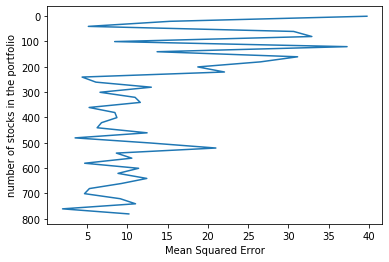

In [26]:
# Plot Efficient Deep Frontier

mse = [e/len(kspi15['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(1, 791, 20)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio')

# Part 2 : Beat KOSPI Index

### 'Amended' KOSPI Index

In [27]:
# # from -5% to 5%
# kspi15_amended = kspi15['calibrate']['pct']
# kspi15_amended[kspi15_amended < -3] = 3

# # re-calculate the last price
# kspi15_amended[0] = 0
# relative_percentage = (kspi15_amended /100) + 1
# kspi15_lp_amended = kspi15['calibrate']['lp'] * (relative_percentage.cumprod())

# # plot comparison
# pd.Series(kspi15['calibrate']['lp'].values, index=kospi15_lp.index[:642]).plot(label='kospi original', legend=True) 
# pd.Series(kspi15_lp_amended.values, index=kospi15_lp.index[:642]).plot(label='kospi amended', legend=True)

###  수정 'Amended' KOSPI Index

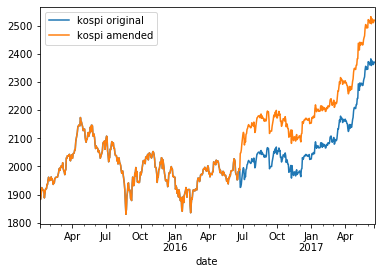

In [28]:
# from -5% to 5%
kspi15_amended = kspi15['calibrate']['pct']
kspi15_amended[kspi15_amended < -3] = 3

# re-calculate the last price
kspi15_amended[0] = 0
relative_percentage = (kspi15_amended /100) + 1

# amended 방식 수정
kspi15_lp_amended = kspi15['calibrate']['lp'][0] * (relative_percentage.cumprod())

# amended 기존 방식
#kspi15_lp_amended_ = kspi15['calibrate']['lp'] * (relative_percentage.cumprod())

# plot comparison
pd.Series(kspi15['calibrate']['lp'].values, index=kospi15_lp.index[:642]).plot(label='kospi original', legend=True) 
pd.Series(kspi15_lp_amended.values, index=kospi15_lp.index[:642]).plot(label='kospi amended', legend=True)

### Beat Phase 2 : Calibrating (Neural Net)

In [29]:
kspi15_predict = defaultdict(defaultdict)
total_2_norm_diff15 = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [140, 330, 520]:  
    # some numerical values
    encoding_dim = 7
    s = 150 + non_communal
    stock_index = np.concatenate((ranking[0:150], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation=swish, kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock15['calibrate']['pct'].iloc[:, stock_index]
    y = kspi15_amended
    #y = pd.DataFrame(y)
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    #dl_scalery = StandardScaler()
    #dl_scalery.fit(y)
    #y = dl_scalery.transform(z)
        
    
    deep_learner.fit(x, y, shuffle=False, epochs=50, batch_size = 10)    # fit the model
    deep_learner.save('Beat_model/D5_beat_2015_200_12' + str(s) + '.h5') # for validation phase use
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    kspi15_predict['calibrate'][s] = kspi15['calibrate']['lp'][0] * (relative_percentage.cumprod())
    total_2_norm_diff15['calibrate'][s] = np.linalg.norm((kspi15_predict['calibrate'][s] - kspi15_lp_amended))

Epoch 1/50
642/642 [==============================] - 0s 314us/step - loss: 0.9187
Epoch 2/50
642/642 [==============================] - 0s 241us/step - loss: 0.3715
Epoch 3/50
642/642 [==============================] - 0s 217us/step - loss: 0.2902
Epoch 4/50
642/642 [==============================] - 0s 230us/step - loss: 0.2527
Epoch 5/50
642/642 [==============================] - 0s 229us/step - loss: 0.2285
Epoch 6/50
642/642 [==============================] - 0s 269us/step - loss: 0.2113
Epoch 7/50
642/642 [==============================] - 0s 245us/step - loss: 0.1981
Epoch 8/50
642/642 [==============================] - 0s 221us/step - loss: 0.1874
Epoch 9/50
642/642 [==============================] - 0s 209us/step - loss: 0.1786
Epoch 10/50
642/642 [==============================] - 0s 214us/step - loss: 0.1710
Epoch 11/50
642/642 [==============================] - 0s 213us/step - loss: 0.1643
Epoch 12/50
642/642 [==============================] - 0s 222us/step - loss: 0.1583
E

S290 2-norm difference:  3969.662110834589
S480 2-norm difference:  1167.7987132659432
S670 2-norm difference:  875.8320989627425
Fix Rank: 150
Encoding Dim: 7
Enco Acti: swish
Deco Acti: linear


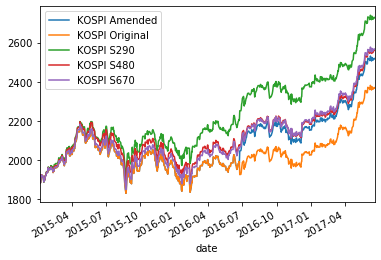

In [30]:
kospi15_plot = pd.DataFrame(kspi15['calibrate']['lp'], index=kospi15_lp.index[:642])
kospi15_plot_lp_amended = pd.DataFrame(kspi15_lp_amended, index=kospi15_lp.index[:642])
plt.plot(kospi15_plot_lp_amended, label='KOSPI Amended')
plt.plot(kospi15_plot, label='KOSPI Original')

pd.Series(kspi15_predict['calibrate'][240+50], index=kospi15_lp.index[:642]).plot(label='KOSPI S290')
pd.Series(kspi15_predict['calibrate'][430+50], index=kospi15_lp.index[:642]).plot(label='KOSPI S480')
pd.Series(kspi15_predict['calibrate'][620+50], index=kospi15_lp.index[:642]).plot(label='KOSPI S670')

print("S" + str(240+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][240+50])
print("S" + str(430+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][430+50])
print("S" + str(620+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][620+50])
print("Fix Rank: 150")
print("Encoding Dim: 7")
print("Enco Acti: swish")
print("Deco Acti: linear")

plt.legend()
plt.show()

### Beat Phase 3 : Validation (Neural Net)

In [31]:

for non_communal in [140, 330, 520]:  
    # some numerical values
    encoding_dim = 7
    s = 150 + non_communal
    stock_index = np.concatenate((ranking[0:150], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('Beat_model/D5_beat_2015_50_12' + str(s) + '.h5', custom_objects={"swish":swish})
        
    x = stock15['validate']['pct'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    kspi15_predict['validate'][s] = kspi15['validate']['lp'][0] * (relative_percentage.cumprod())          
    #total_2_norm_diff15['validate'][s] = np.linalg.norm((kspi15_predict['validate'][s] - kspi15['validate']['lp']))

Fix Rank: 150
Encoding Dim: 7
Enco Acti: swish
Deco Acti: linear


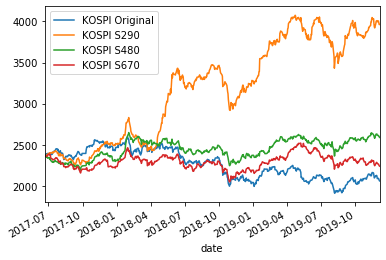

In [32]:
kospi15_plot = pd.DataFrame(kspi15['validate']['lp'], index=kospi15_lp.index[642:])
kospi15_plot_lp_amended = pd.DataFrame(kspi15_lp_amended, index=kospi15_lp.index[642:])
#plt.plot(kospi15_plot_lp_amended, label='KOSPI Amended')
plt.plot(kospi15_plot, label='KOSPI Original')

pd.Series(kspi15_predict['validate'][240+50], index=kospi15_lp.index[642:]).plot(label='KOSPI S290')
pd.Series(kspi15_predict['validate'][430+50], index=kospi15_lp.index[642:]).plot(label='KOSPI S480')
pd.Series(kspi15_predict['validate'][620+50], index=kospi15_lp.index[642:]).plot(label='KOSPI S670')

#print("S" + str(240+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][240+50])
#print("S" + str(430+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][430+50])
#print("S" + str(620+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][620+50])
print("Fix Rank: 150")
print("Encoding Dim: 7")
print("Enco Acti: swish")
print("Deco Acti: linear")

plt.legend()
plt.show()

###  Sharp Ratio

In [33]:
# calculate daily stock returns for S&P
benchmark = kospi15_plot.copy()
benchmark_returns = kospi15_plot.pct_change().dropna()
#benchmark_returns = benchmark_returns.astype(np.int32)

In [34]:
# calculate daily stock returns for the banks

a = pd.DataFrame(kspi15_predict['validate'][240+50], columns=['s290'])
a['s480']=pd.DataFrame(kspi15_predict['validate'][430+50])
a['s670']=pd.DataFrame(kspi15_predict['validate'][620+50])

stock_returns = a.pct_change().dropna()
stock_returns.index=benchmark_returns.index

In [1]:
import seaborn as sns
sns.set()

# calculate the difference in daily returns for stocks vs S&P
excess_returns = stock_returns - benchmark_returns
#stock_returns.info()
#benchmark_returns.info()

# calculate the mean of excess_returns 
avg_excess_return = excess_returns.mean()
avg_excess_benchmark_return = benchmark_returns.mean()

avg_excess_return.plot.bar(title='Average of excess return')
# calculate the standard deviation for daily excess return
std_excess_return = excess_returns.std()
std_excess_benchmark_return = benchmark_returns.std()

std_excess_return.plot.bar(title='Standard Deviation of the excess return')
# calculate the daily sharpe ratio
daily_sharpe_ratio = avg_excess_return.div(std_excess_return)
daily_sharpe_ratio_benchmark = avg_excess_benchmark_return.div(std_excess_benchmark_return)

# annualize the sharpe ratio
ann = np.sqrt(len(benchmark))
annual_sharpe_ratio = daily_sharpe_ratio.mul(ann)
annual_sharpe_ratio_benchmark = daily_sharpe_ratio_benchmark.mul(ann)

annual_sharpe_ratio.plot.bar(title='Sharpe Ratio: Stocks vs KOSPI Index')

NameError: name 'stock_returns' is not defined